# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('/home/jovyan/data_preprocessing')

### Set file paths

In [2]:
subreddit_here = "politics"
subreddit = "politics"


output_path = f"../../data/new_preprocessing/{subreddit_here}_new_preprocessing_com_rep.csv"



In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
#import community as community_louvain

import zstandard
import io
import zipfile

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
from collections import Counter
import multiprocessing
import copy
import time
#import gurobipy
#from gurobipy import *

pd.options.mode.chained_assignment = None

In [4]:
import sys
sys.path

['/home/jovyan/data_preprocessing/politics',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/data_preprocessing']

In [5]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels
from preprocessing_functions import import_subreddit_to_parquet

***

## **Data Import**

In [ ]:
# write comments 1 to parquet
#import_subreddit_to_parquet(file_comments, "../../data/raw_data/politics_comments_parquet_new.zst", chunk_size=100_000, data_type="comments")

# write submissions 1 to parquet
#import_subreddit_to_parquet(file_submissions, "../../data/raw_data/politics_submissions_parquet_new.zst", chunk_size=100_000, data_type="submissions")



In [6]:
# import
data_comments = pd.read_parquet("../../data/raw_data/politics_comments_parquet_new.zst", engine="pyarrow")
data_submissions = pd.read_parquet("../../data/raw_data/politics_submissions_parquet_new.zst", engine="pyarrow")

IOStream.flush timed out


In [7]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [8]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

Nr. of pulled submissions 4609228


In [9]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)


Nr. of pulled comments & replies 187786794


In [10]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

# 51187999 and 37509265

Nr. of comments 51187999
Nr. of replies 37509265


### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

In [11]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
print(relevant_submissions['count'].mean())
relevant_submissions
# get nr of submissions, for which I do have comments --> 29.304


14.523119730056315


,submission_id,count
0,10002q,1
1,1000ce,7
2,1000dde,3
3,1000elx,1
4,1000en,8
...,...,...
3524582,zzzngt,12
3524583,zzzp6h,1
3524584,zzzq7x,5
3524585,zzzte,1


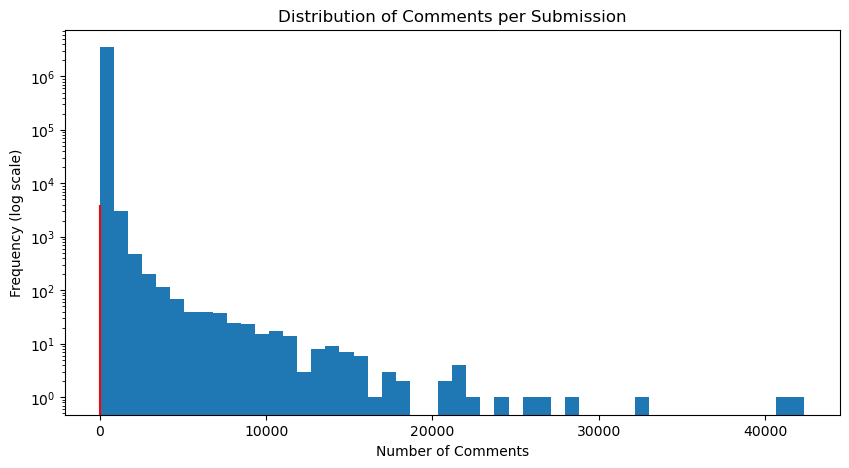

In [12]:
# Histogram
plt.figure(figsize=(10, 5))
plt.hist(relevant_submissions['count'], bins=50)
plt.vlines((relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4000)

plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Number of Comments")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Comments per Submission")
plt.show()


In [13]:
plt_data = pd.DataFrame(relevant_submissions['count'].value_counts()).rename(columns={'count' : 'class_count'}).reset_index().rename(columns={'count' : 'comment_count'}).sort_values(by = "comment_count").reset_index(drop=True)

plt_data['log_com_count'] = plt_data['comment_count'].apply(lambda x: np.log10(x))
plt_data['log_class_count'] = plt_data['class_count'].apply(lambda x: np.log10(x))
plt_data

,comment_count,class_count,log_com_count,log_class_count
0,1,946110,0.000000,5.975942
1,2,538094,0.301030,5.730858
2,3,321493,0.477121,5.507172
3,4,232412,0.602060,5.366259
4,5,181478,0.698970,5.258824
...,...,...,...,...
2581,26321,1,4.420302,0.000000
2582,28766,1,4.458879,0.000000
2583,32391,1,4.510424,0.000000
2584,41250,1,4.615424,0.000000


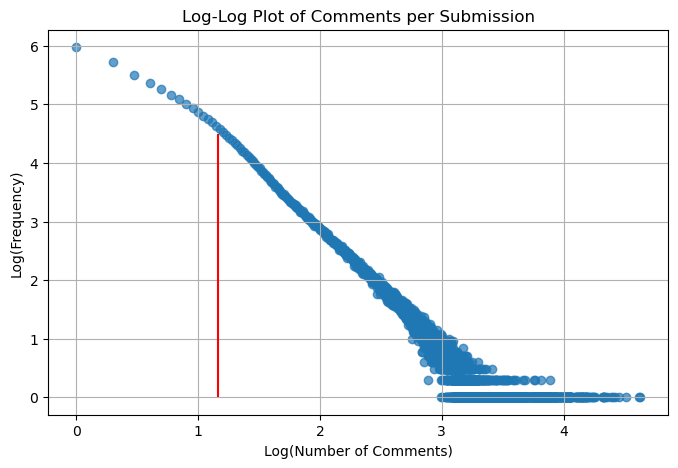

In [14]:
plt.figure(figsize=(8, 5))
plt.scatter(plt_data['log_com_count'], plt_data['log_class_count'], alpha=0.7)
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4.5)

plt.xlabel("Log(Number of Comments)")
plt.ylabel("Log(Frequency)")
plt.title("Log-Log Plot of Comments per Submission")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Nr. of submissions')

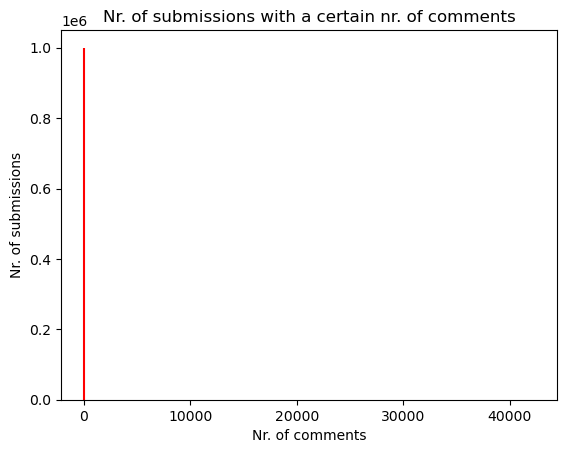

In [15]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['comment_count'], height = plt_data['class_count'])
plt.vlines(relevant_submissions['count'].mean(), colors="red", ymin = 0, ymax=1000000)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

Text(0, 0.5, 'Nr. of submissions')

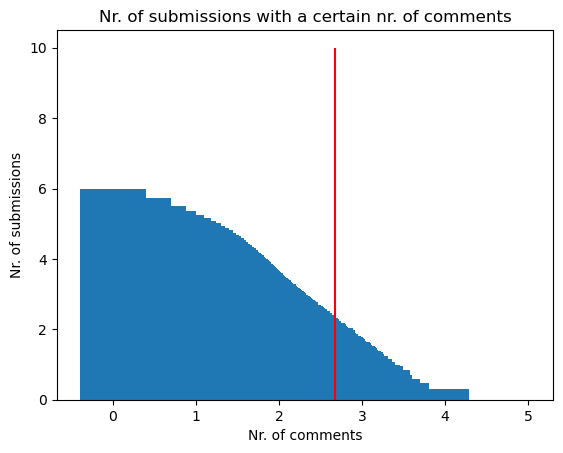

In [16]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['log_com_count'], height = plt_data['log_class_count'])
plt.vlines(np.log(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=10)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

In [17]:
# select relevant submissions (by avg. number of comments)

relevant_submissions, relevant_comments, empty_submissions, empty_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


Mean nr. of comments per submission 14.523119730056315
Nr. of submission, that I have comments for 3524587
All submissions found
Removing empty submissions deleted 3449612 submissions
Empty submissions in df_submissions_empty: 3449612
Kept 74975 submissions
Nr. of comments, whose submission is retaied 5131564
Share 0.10024935727610684
Nr. of comments, whose submission is empty 46056435
Share 0.8997506427238932


In [18]:

print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments




Number of relevant submissions: 74975
Lost submissions:  4534253


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,garyp714,1.245350e+09,8to0h,2cneq,No link?,8to0h,c0ae377,c0ae377,1,1,0,politics,None,None,None,None,None,2009-06-18,comment
1,risdn,1.245356e+09,8tp50,2cneq,Well said.,8tp50,c0ae7gx,c0ae7gx,3,3,0,politics,None,None,None,None,None,2009-06-18,comment
2,skratchx,1.245358e+09,8tp50,2cneq,I agree with you. The only thing I can think ...,8tp50,c0ae8hz,c0ae8hz,1,1,0,politics,None,None,None,None,None,2009-06-18,comment
3,[deleted],1.245358e+09,8tp9j,2cneq,We can do something. It's called voting. Sto...,8tp9j,c0ae8k8,c0ae8k8,2,2,0,politics,None,None,None,None,None,2009-06-18,comment
4,robkinyon,1.245358e+09,8tp9j,2cneq,DownsizeDC.org has a push for something called...,8tp9j,c0ae8qy,c0ae8qy,2,2,0,politics,None,None,None,None,None,2009-06-18,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131559,croolshooz,1.703964e+09,18uirzt,2cneq,Mike Stanfill - 2023 in Review\n\n[August](htt...,18uirzt,kflblhg,kflblhg,16,16,0,politics,None,,False,True,None,2023-12-30,comment
5131560,[deleted],1.703967e+09,18uirzt,2cneq,[removed],18uirzt,kfll946,kfll946,1,1,0,politics,None,,False,True,None,2023-12-30,comment
5131561,illgu_18,1.703978e+09,18mfyba,2cneq,Ok. Say he’s immune from crimes. Wouldn’t it b...,18mfyba,kfmd2s6,kfmd2s6,1,1,0,politics,None,,False,True,None,2023-12-30,comment
5131562,DoubleTFan,1.703983e+09,18uirzt,2cneq,Courtesy the Star Tribune's Steve Sack: https:...,18uirzt,kfmq5kr,kfmq5kr,5,5,0,politics,None,,False,True,None,2023-12-31,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [19]:

df_matched, com_per_sub, rep_per_com = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner', subreddit_here)
df_matched

Nr. of unique replies 6637133
Nr. of unique comments 2247130
Nr. of unique submissions 56489
A submission receives on average 39.77995715980102 comments.
A comment receives on average 2.953604375358791 replies.
Share of matched submissions: 0.7534378126042014


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0ae8k8,c0ae911,You might disagree with me calling this a prob...,politics,1.245359e+09,skratchx,1,1,0,8tp9j,...,[deleted],2,2,0,1.245358e+09,It's crazy that some important laws *don't* pa...,skratchx,None,5,1.245357e+09
1,c0ae8rw,c0ae9vp,They are the exact same except that Olberman s...,politics,1.245360e+09,InCahoots,-8,-8,0,8tp50,...,[deleted],11,11,0,1.245358e+09,The video from last nights World's Worst is wo...,hyperbolic,None,77,1.245356e+09
2,c0ae8rw,c0aecm5,&gt; Olberman is sharp **and intellectually ho...,politics,1.245365e+09,masklinn,1,1,0,8tp50,...,[deleted],11,11,0,1.245358e+09,The video from last nights World's Worst is wo...,hyperbolic,None,77,1.245356e+09
3,c0ae8rw,c0aei8s,If you think any of these pundits are 'intelle...,politics,1.245377e+09,[deleted],4,4,0,8tp50,...,[deleted],11,11,0,1.245358e+09,The video from last nights World's Worst is wo...,hyperbolic,None,77,1.245356e+09
4,c0ae8rw,c0aej8c,[deleted],politics,1.245380e+09,[deleted],1,1,0,8tp50,...,[deleted],11,11,0,1.245358e+09,The video from last nights World's Worst is wo...,hyperbolic,None,77,1.245356e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6637131,kfkhr0u,kformn9,[removed],politics,1.704023e+09,[deleted],1,1,0,18uirzt,...,Georgiachemscientist,15,15,0,1.703953e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,49,49,1.703952e+09
6637132,kfklsb6,kforzbx,This is such a spot on interpretation of what'...,politics,1.704023e+09,bakerfredricka,3,3,0,18uirzt,...,4blockhead,27,27,0,1.703954e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,49,49,1.703952e+09
6637133,kfmq5kr,kfp6tzv,Voting is not nearly that simple. In a first ...,politics,1.704032e+09,glassjar1,3,3,0,18uirzt,...,DoubleTFan,5,5,0,1.703983e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,49,49,1.703952e+09
6637134,kfp3d4v,kfp8xh8,"also, try explaining why biden is better to a ...",politics,1.704033e+09,HaulinBoats,4,4,0,18uirzt,...,4blockhead,9,9,0,1.704030e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,49,49,1.703952e+09


In [20]:
df_matched_empty, com_per_sub_empty, rep_per_com_empty = match_reply_comment_submission(replies, empty_comments, empty_submissions, 'inner', subreddit_here)
df_matched_empty


Nr. of unique replies 29637174
Nr. of unique comments 12562976
Nr. of unique submissions 1791328
A submission receives on average 7.013219242930385 comments.
A comment receives on average 2.3590886426910314 replies.
Share of matched submissions: 0.519283907871378


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c2cnq9,c2co07,[deleted],politics,1.186383e+09,[deleted],17,17,None,2cnnc,...,lojomofo,6,6,None,1.186380e+09,,Xiphorian,None,66,1.186379e+09
1,c2cnq9,c2cpoi,Yeah people on Fox News especially always make...,politics,1.186405e+09,Omikron,3,3,None,2cnnc,...,lojomofo,6,6,None,1.186380e+09,,Xiphorian,None,66,1.186379e+09
2,c2cnq9,c2crhb,Knowing that she chooses to work for Fox News ...,politics,1.186417e+09,lastshot,6,6,None,2cnnc,...,lojomofo,6,6,None,1.186380e+09,,Xiphorian,None,66,1.186379e+09
3,c2coeu,c2criv,His domestic policy will certainly 'take care'...,politics,1.186418e+09,aradil,-2,-2,None,2cnnc,...,genericerik,10,10,None,1.186389e+09,,Xiphorian,None,66,1.186379e+09
4,c2cpam,c2cs4h,ya I caught that too. all of the emailed quest...,politics,1.186421e+09,bamdastard,1,1,None,2cnnc,...,[deleted],11,11,None,1.186402e+09,,Xiphorian,None,66,1.186379e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29637571,kfrh2km,kfrotha,"Absolutely. They are trafficking humans, which...",politics,1.704067e+09,Science-Sam,46,46,0,18vizm7,...,Fun-Persimmon1207,189,189,0,1.704064e+09,,TheTruthTalker800,3035,3035,1.704062e+09
29637572,kfrj8kw,kfrjud5,[removed],politics,1.704065e+09,[deleted],1,1,0,18vjps0,...,goforthandconquer,12,12,0,1.704065e+09,,iguess12,1,1,1.704065e+09
29637573,kfrj8kw,kfrk6bu,They spiked right when Biden took office. Whic...,politics,1.704065e+09,ScaryBuilder9886,-21,-21,0,18vjps0,...,goforthandconquer,12,12,0,1.704065e+09,,iguess12,1,1,1.704065e+09
29637574,kfrkejm,kfrlkvt,Can you explain that a little more?,politics,1.704066e+09,Extension_Use3118,1,1,0,18vjps0,...,MazingerZeta28,9,9,0,1.704065e+09,,iguess12,1,1,1.704065e+09


In [21]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


In [22]:

com_per_sub_empty = com_per_sub_empty.rename(columns={0 : 'nr_comments'})
rep_per_com_empty = rep_per_com_empty.rename(columns={0 : 'nr_replies'})

com_per_sub = com_per_sub.rename(columns={0 : 'nr_comments'})
rep_per_com = rep_per_com.rename(columns={0 : 'nr_replies'})


df_matched.to_csv(f"output/{subreddit_here}_df_matched.csv", index = False)
com_per_sub.to_csv(f"output/{subreddit_here}_com_per_sub.csv", index = False)
rep_per_com.to_csv(f"output/{subreddit_here}_rep_per_com.csv", index = False)

df_matched_empty.to_csv(f"output/{subreddit_here}_df_matched_empty.csv", index = False)
com_per_sub_empty.to_csv(f"output/{subreddit_here}_com_per_sub_empty.csv", index = False)
rep_per_com_empty.to_csv(f"output/{subreddit_here}_rep_per_com_empty.csv", index = False)

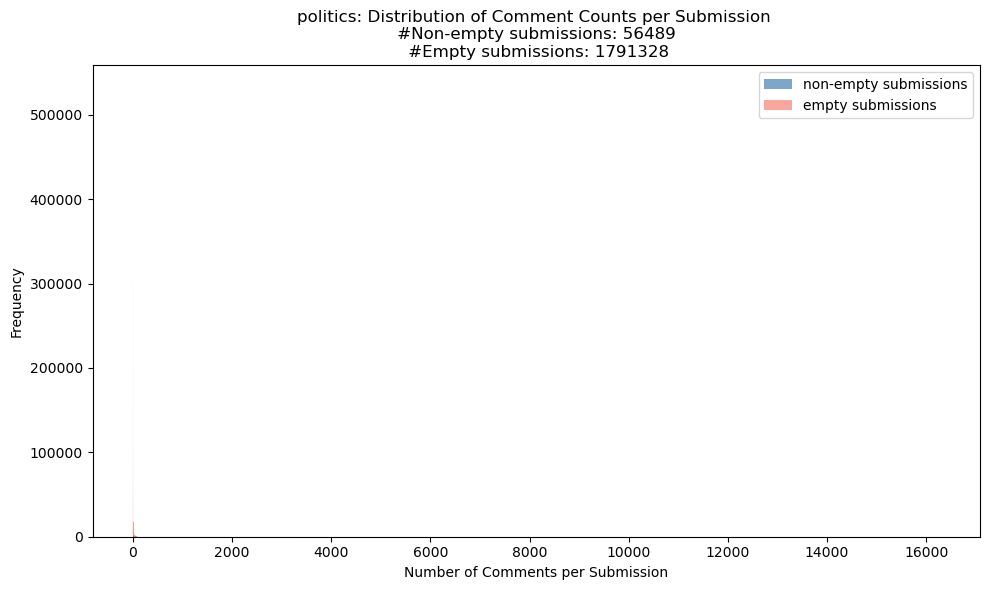

In [16]:
plt.figure(figsize=(10, 6))

sns.histplot(com_per_sub[0], binwidth=1, kde=False, label='non-empty submissions', color='steelblue', alpha=0.7)
sns.histplot(com_per_sub_empty[0], binwidth=1, kde=False, label='empty submissions', color='salmon', alpha=0.7)

plt.xlabel('Number of Comments per Submission')
#plt.xlim(0, 100)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n #Non-empty submissions: {len(com_per_sub[0])} \n #Empty submissions: {len(com_per_sub_empty[0])}')
plt.legend()
plt.tight_layout()

plt.savefig(f"Hist_nolim_{subreddit_here}_Comments_per_Submission.pdf")
plt.show()


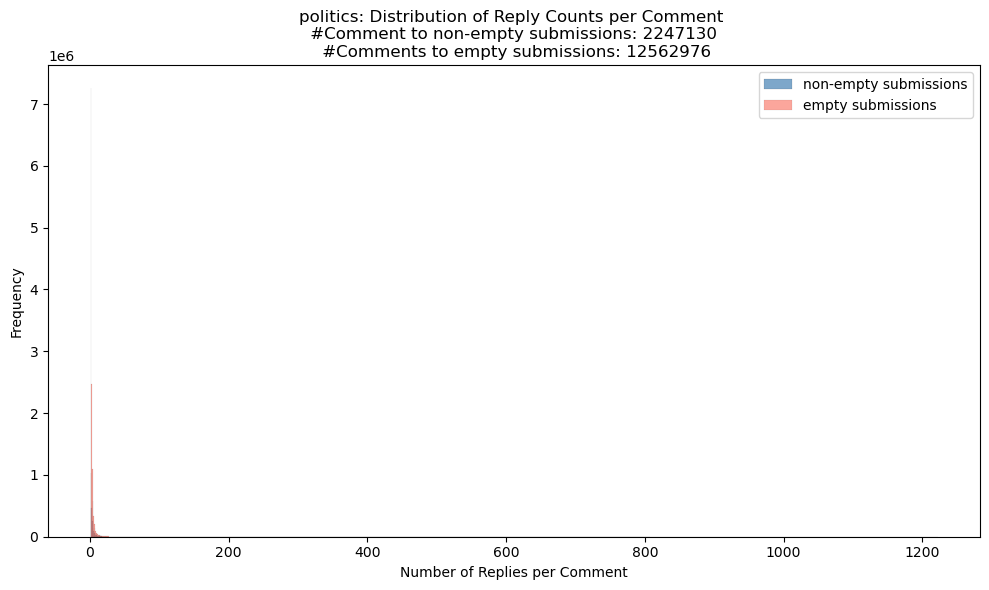

In [17]:
plt.figure(figsize=(10, 6))


sns.histplot(rep_per_com[0], binwidth=1, kde=False, label='non-empty submissions', color='steelblue', alpha=0.7)
sns.histplot(rep_per_com_empty[0], binwidth=1, kde=False, label='empty submissions', color='salmon', alpha=0.7)


plt.xlabel('Number of Replies per Comment')
#plt.xlim(0, 40)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n #Comment to non-empty submissions: {len(rep_per_com[0])} \n #Comments to empty submissions: {len(rep_per_com_empty[0])}')
plt.legend()
plt.tight_layout()
plt.savefig(f"Hist_nolim_{subreddit_here}_Replies_per_Comment.pdf")
plt.show()


/tmp/ipykernel_307/1653069568.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])


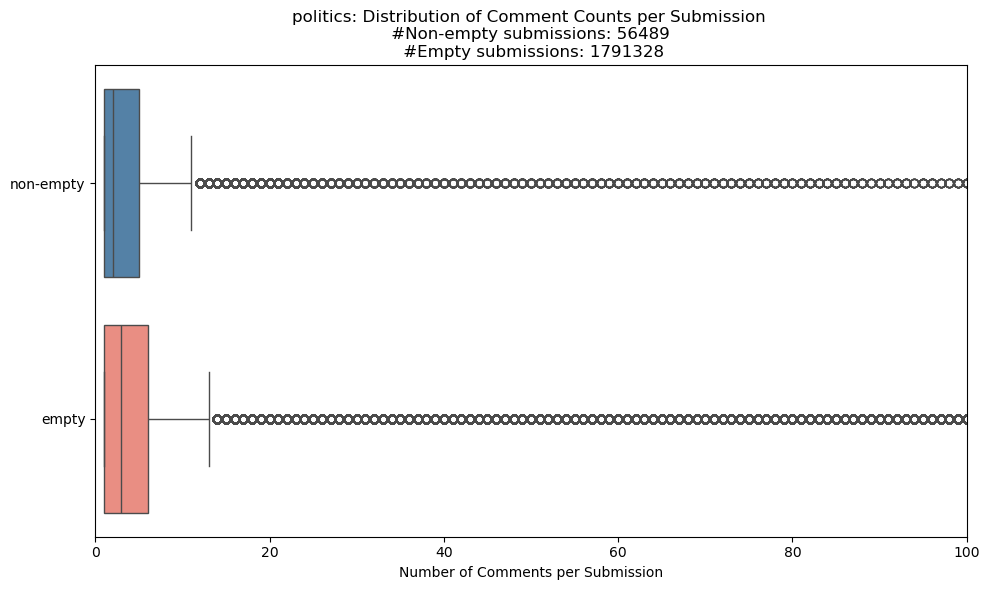

In [21]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([com_per_sub[0], com_per_sub_empty[0]], ignore_index=True),
    'type': ['non-empty'] * len(com_per_sub[0]) + ['empty'] * len(com_per_sub_empty[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Comments per Submission')
plt.ylabel('')
plt.xlim(0, 100)
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n #Non-empty submissions: {len(com_per_sub[0])} \n #Empty submissions: {len(com_per_sub_empty[0])}')
plt.savefig(f"Box_lim_{subreddit_here}_Comments_per_Submission.pdf")

plt.tight_layout()
plt.show()

/tmp/ipykernel_307/4117994619.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])


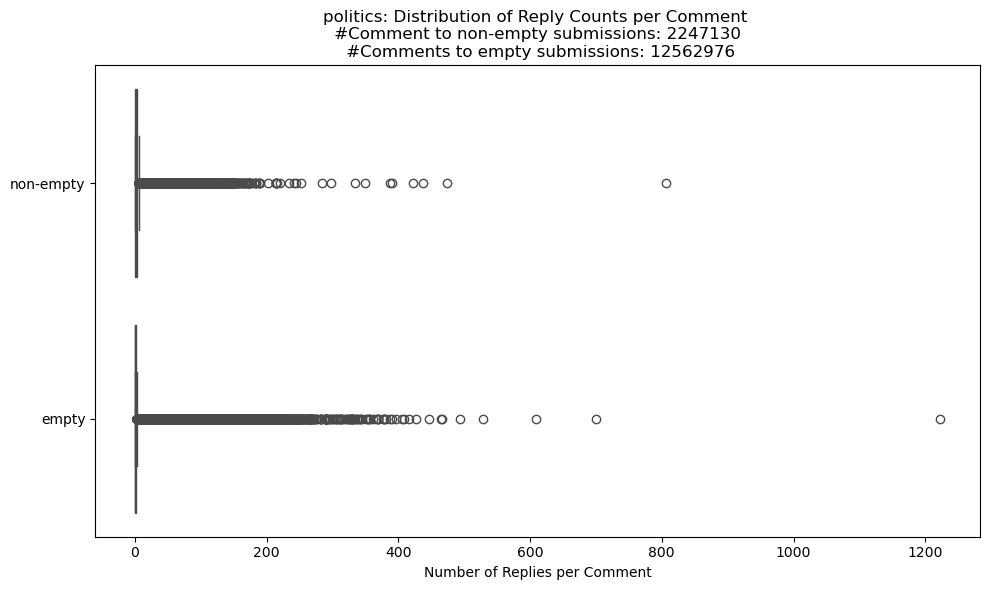

In [23]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([rep_per_com[0], rep_per_com_empty[0]], ignore_index=True),
    'type': ['non-empty'] * len(rep_per_com[0]) + ['empty'] * len(rep_per_com_empty[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Replies per Comment')
plt.ylabel('')
#plt.xlim(0, 100)
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n #Comment to non-empty submissions: {len(rep_per_com[0])} \n #Comments to empty submissions: {len(rep_per_com_empty[0])}')
plt.savefig(f"Box_nolim_{subreddit_here}_Replies_per_Comment.pdf")

plt.tight_layout()
plt.show()


### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [22]:
df_matched['body_child'].value_counts().head(5)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

body_child
[deleted]    262907
[removed]    227481
Yes           11692
Nice           7616
No             6402
Name: count, dtype: int64

In [23]:
# remove interactions where either comment or reply (or both) are shorter than 5 words

df = preprocess_texts(data = df_matched, length = 5)
df

Deleting all interactions with empty texts removed 1079907 interactions. Share:  0.16270677593468025
Kept 5557229 interactions.
Deleting empty authors deleted 367107 interactions. Share:  0.06605936159909911
Kept 5190122 interactions.


IOStream.flush timed out


Length 5 removes 1011351 interactions
Kept 4178771 interactions
Drop duplicates (in parent & child text and author) removed 26 interactions. Share:  6.2219250588271045e-06
Kept 4178745 interactions.
After text cleaning 1724 interactions had empty texts and got removed. Share:  0.000412564059304887
Kept 4177021 interactions.


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0ae9r5,c0aeb6y,That is what I'm looking for. Links would be a...,politics,1.245362e+09,hyperbolic,7,7,0,8tp50,...,pb1x,16,16,0,1.245360e+09,The video from last nights World's Worst is wo...,hyperbolic,None,77,1.245356e+09
1,c0aeds9,c0aee4d,As an addendum about their respective networks...,politics,1.245368e+09,OMFG-Spot,7,7,0,8tp50,...,OMFG-Spot,5,5,0,1.245367e+09,The video from last nights World's Worst is wo...,hyperbolic,None,77,1.245356e+09
2,c0aeds9,c0aeglj,"That's awesome and all, but do you have any ev...",politics,1.245373e+09,hyperbolic,2,2,0,8tp50,...,OMFG-Spot,5,5,0,1.245367e+09,The video from last nights World's Worst is wo...,hyperbolic,None,77,1.245356e+09
3,c0aeds9,c0aehqw,I don't understand your argument. Are you sayi...,politics,1.245376e+09,rocketvat,3,3,0,8tp50,...,OMFG-Spot,5,5,0,1.245367e+09,The video from last nights World's Worst is wo...,hyperbolic,None,77,1.245356e+09
4,c0aecro,c0aegcb,don't you have anything better to do than whin...,politics,1.245372e+09,clorby,0,0,0,8tp50,...,Laughsatyou,0,0,0,1.245365e+09,The video from last nights World's Worst is wo...,hyperbolic,None,77,1.245356e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177016,kfkh5ib,kfmd52k,Fact-checking doesnt work if no one hears you ...,politics,1.703978e+09,Knightforlife,8,8,0,18uirzt,...,freddiethebaer,26,26,0,1.703953e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,49,49,1.703952e+09
4177017,kfklsb6,kforzbx,This is such a spot on interpretation of what'...,politics,1.704023e+09,bakerfredricka,3,3,0,18uirzt,...,4blockhead,27,27,0,1.703954e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,49,49,1.703952e+09
4177018,kfmq5kr,kfp6tzv,Voting is not nearly that simple. In a first p...,politics,1.704032e+09,glassjar1,3,3,0,18uirzt,...,DoubleTFan,5,5,0,1.703983e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,49,49,1.703952e+09
4177019,kfp3d4v,kfp8xh8,"also, try explaining why biden is better to a ...",politics,1.704033e+09,HaulinBoats,4,4,0,18uirzt,...,4blockhead,9,9,0,1.704030e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,49,49,1.703952e+09


In [24]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


1. Check number of empty submissions

How many would we loose?

2. Redo author list

3. Select only relevant columns

In [25]:
df.columns

Index(['msg_id_parent', 'msg_id_child', 'body_child', 'subreddit',
       'exact_time_child', 'author_child', 'ups_child', 'score_child',
       'downs_child', 'submission_id', 'body_parent', 'author_parent',
       'ups_parent', 'score_parent', 'downs_parent', 'exact_time_parent',
       'submission_text', 'author_submission', 'ups_submission',
       'score_submission', 'exact_time_submission'],
      dtype='object')

In [109]:
df_filtered = df[['msg_id_parent', 'msg_id_child', 'submission_id', 'subreddit',
    'body_child', 'body_parent', 'submission_text',
    'exact_time_child', 'exact_time_parent', 'exact_time_submission',
    'author_child', 'author_parent', 'author_submission']]
df_filtered

,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,exact_time_parent,exact_time_submission,author_child,author_parent,author_submission
0,c0ae9r5,c0aeb6y,8tp50,politics,That is what I'm looking for. Links would be a...,O'Reilly was actually against FISA and Bush on...,The video from last nights World's Worst is wo...,1.245362e+09,1.245360e+09,1.245356e+09,hyperbolic,pb1x,hyperbolic
1,c0aeds9,c0aee4d,8tp50,politics,As an addendum about their respective networks...,Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,1.245368e+09,1.245367e+09,1.245356e+09,OMFG-Spot,OMFG-Spot,hyperbolic
2,c0aeds9,c0aeglj,8tp50,politics,"That's awesome and all, but do you have any ev...",Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,1.245373e+09,1.245367e+09,1.245356e+09,hyperbolic,OMFG-Spot,hyperbolic
3,c0aeds9,c0aehqw,8tp50,politics,I don't understand your argument. Are you sayi...,Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,1.245376e+09,1.245367e+09,1.245356e+09,rocketvat,OMFG-Spot,hyperbolic
4,c0aecro,c0aegcb,8tp50,politics,don't you have anything better to do than whin...,"waaah FOX NEWS, do you people have anything be...",The video from last nights World's Worst is wo...,1.245372e+09,1.245365e+09,1.245356e+09,clorby,Laughsatyou,hyperbolic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177016,kfkh5ib,kfmd52k,18uirzt,politics,Fact-checking doesnt work if no one hears you ...,Jen Sorensen Future veterans of the informatio...,"It's Saturday, folks. Let's all kick back with...",1.703978e+09,1.703953e+09,1.703952e+09,Knightforlife,freddiethebaer,optimalg
4177017,kfklsb6,kforzbx,18uirzt,politics,This is such a spot on interpretation of what'...,Yakima Herald-Republic and other papers in syn...,"It's Saturday, folks. Let's all kick back with...",1.704023e+09,1.703954e+09,1.703952e+09,bakerfredricka,4blockhead,optimalg
4177018,kfmq5kr,kfp6tzv,18uirzt,politics,Voting is not nearly that simple. In a first p...,Courtesy the Star Tribune's Steve Sack,"It's Saturday, folks. Let's all kick back with...",1.704032e+09,1.703983e+09,1.703952e+09,glassjar1,DoubleTFan,optimalg
4177019,kfp3d4v,kfp8xh8,18uirzt,politics,"also, try explaining why biden is better to a ...",Doonesbury by Trudeau ...explain it like I'm ...,"It's Saturday, folks. Let's all kick back with...",1.704033e+09,1.704030e+09,1.703952e+09,HaulinBoats,4blockhead,optimalg


,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,exact_time_parent,exact_time_submission,author_child,author_parent,author_submission
0,c0ae9r5,c0aeb6y,8tp50,politics,That is what I'm looking for. Links would be a...,O'Reilly was actually against FISA and Bush on...,The video from last nights World's Worst is wo...,2009-06-18 21:57:58,2009-06-18 21:19:15,2009-06-18 20:18:01,hyperbolic,pb1x,hyperbolic
1,c0aeds9,c0aee4d,8tp50,politics,As an addendum about their respective networks...,Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,2009-06-18 23:27:00,2009-06-18 23:15:44,2009-06-18 20:18:01,OMFG-Spot,OMFG-Spot,hyperbolic
2,c0aeds9,c0aeglj,8tp50,politics,"That's awesome and all, but do you have any ev...",Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,2009-06-19 00:57:11,2009-06-18 23:15:44,2009-06-18 20:18:01,hyperbolic,OMFG-Spot,hyperbolic
3,c0aeds9,c0aehqw,8tp50,politics,I don't understand your argument. Are you sayi...,Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,2009-06-19 01:43:48,2009-06-18 23:15:44,2009-06-18 20:18:01,rocketvat,OMFG-Spot,hyperbolic
4,c0aecro,c0aegcb,8tp50,politics,don't you have anything better to do than whin...,"waaah FOX NEWS, do you people have anything be...",The video from last nights World's Worst is wo...,2009-06-19 00:47:08,2009-06-18 22:44:27,2009-06-18 20:18:01,clorby,Laughsatyou,hyperbolic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177016,kfkh5ib,kfmd52k,18uirzt,politics,Fact-checking doesnt work if no one hears you ...,Jen Sorensen Future veterans of the informatio...,"It's Saturday, folks. Let's all kick back with...",2023-12-30 23:13:16,2023-12-30 16:09:00,2023-12-30 16:01:55,Knightforlife,freddiethebaer,optimalg
4177017,kfklsb6,kforzbx,18uirzt,politics,This is such a spot on interpretation of what'...,Yakima Herald-Republic and other papers in syn...,"It's Saturday, folks. Let's all kick back with...",2023-12-31 11:43:44,2023-12-30 16:38:58,2023-12-30 16:01:55,bakerfredricka,4blockhead,optimalg
4177018,kfmq5kr,kfp6tzv,18uirzt,politics,Voting is not nearly that simple. In a first p...,Courtesy the Star Tribune's Steve Sack,"It's Saturday, folks. Let's all kick back with...",2023-12-31 14:14:19,2023-12-31 00:38:00,2023-12-30 16:01:55,glassjar1,DoubleTFan,optimalg
4177019,kfp3d4v,kfp8xh8,18uirzt,politics,"also, try explaining why biden is better to a ...",Doonesbury by Trudeau ...explain it like I'm ...,"It's Saturday, folks. Let's all kick back with...",2023-12-31 14:31:09,2023-12-31 13:44:29,2023-12-30 16:01:55,HaulinBoats,4blockhead,optimalg


4. Check data types for all columns

In [110]:
print(df_filtered.dtypes)

msg_id_parent             object
msg_id_child              object
submission_id             object
subreddit                 object
body_child                object
body_parent               object
submission_text           object
exact_time_child         float64
exact_time_parent        float64
exact_time_submission    float64
author_child              object
author_parent             object
author_submission         object
dtype: object


In [111]:
df_filtered['msg_id_parent'] = df_filtered['msg_id_parent'].astype(str)
df_filtered['msg_id_child'] = df_filtered['msg_id_child'].astype(str)
df_filtered['submission_id'] = df_filtered['submission_id'].astype(str)

df_filtered['body_child'] = df_filtered['body_child'].astype(str)
df_filtered['body_parent'] = df_filtered['body_parent'].astype(str)
df_filtered['submission_text'] = df_filtered['submission_text'].astype(str)


df_filtered['author_child'] = df_filtered['author_child'].astype(str)
df_filtered['author_parent'] = df_filtered['author_parent'].astype(str)
df_filtered['author_submission'] = df_filtered['author_submission'].astype(str)

In [112]:
missing_columns = df_filtered.isnull().sum()
print("Missing values in each column:\n", missing_columns)

Missing values in each column:
 msg_id_parent            0
msg_id_child             0
submission_id            0
subreddit                0
body_child               0
body_parent              0
submission_text          0
exact_time_child         0
exact_time_parent        0
exact_time_submission    0
author_child             0
author_parent            0
author_submission        0
dtype: int64


In [113]:
missing_rows = df_filtered.isnull().sum(axis=1)
print("Missing values in each row:\n", missing_rows)

Missing values in each row:
 0          0
1          0
2          0
3          0
4          0
          ..
4177016    0
4177017    0
4177018    0
4177019    0
4177020    0
Length: 4177021, dtype: int64


In [114]:
if df_filtered.isnull().values.any():
    print("\nThere are missing values in the DataFrame!")
else:
    print("\nNo missing values in the DataFrame.")

# 4. Total number of missing values
print(f"\nTotal missing values: {df_filtered.isnull().sum().sum()}")


No missing values in the DataFrame.

Total missing values: 0


# **CONVERSION TO STRING MAKES DATES MESSED UP**

In [115]:
df_filtered

,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,exact_time_parent,exact_time_submission,author_child,author_parent,author_submission
0,c0ae9r5,c0aeb6y,8tp50,politics,That is what I'm looking for. Links would be a...,O'Reilly was actually against FISA and Bush on...,The video from last nights World's Worst is wo...,1.245362e+09,1.245360e+09,1.245356e+09,hyperbolic,pb1x,hyperbolic
1,c0aeds9,c0aee4d,8tp50,politics,As an addendum about their respective networks...,Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,1.245368e+09,1.245367e+09,1.245356e+09,OMFG-Spot,OMFG-Spot,hyperbolic
2,c0aeds9,c0aeglj,8tp50,politics,"That's awesome and all, but do you have any ev...",Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,1.245373e+09,1.245367e+09,1.245356e+09,hyperbolic,OMFG-Spot,hyperbolic
3,c0aeds9,c0aehqw,8tp50,politics,I don't understand your argument. Are you sayi...,Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,1.245376e+09,1.245367e+09,1.245356e+09,rocketvat,OMFG-Spot,hyperbolic
4,c0aecro,c0aegcb,8tp50,politics,don't you have anything better to do than whin...,"waaah FOX NEWS, do you people have anything be...",The video from last nights World's Worst is wo...,1.245372e+09,1.245365e+09,1.245356e+09,clorby,Laughsatyou,hyperbolic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177016,kfkh5ib,kfmd52k,18uirzt,politics,Fact-checking doesnt work if no one hears you ...,Jen Sorensen Future veterans of the informatio...,"It's Saturday, folks. Let's all kick back with...",1.703978e+09,1.703953e+09,1.703952e+09,Knightforlife,freddiethebaer,optimalg
4177017,kfklsb6,kforzbx,18uirzt,politics,This is such a spot on interpretation of what'...,Yakima Herald-Republic and other papers in syn...,"It's Saturday, folks. Let's all kick back with...",1.704023e+09,1.703954e+09,1.703952e+09,bakerfredricka,4blockhead,optimalg
4177018,kfmq5kr,kfp6tzv,18uirzt,politics,Voting is not nearly that simple. In a first p...,Courtesy the Star Tribune's Steve Sack,"It's Saturday, folks. Let's all kick back with...",1.704032e+09,1.703983e+09,1.703952e+09,glassjar1,DoubleTFan,optimalg
4177019,kfp3d4v,kfp8xh8,18uirzt,politics,"also, try explaining why biden is better to a ...",Doonesbury by Trudeau ...explain it like I'm ...,"It's Saturday, folks. Let's all kick back with...",1.704033e+09,1.704030e+09,1.703952e+09,HaulinBoats,4blockhead,optimalg


In [116]:
df_filtered

for column in df_filtered.select_dtypes(include=['object']).columns:  # Only apply to string columns
    df_filtered[column] = df_filtered[column].apply(lambda x: f'"{x}"' if isinstance(x, str) else x)


df_filtered

,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,exact_time_parent,exact_time_submission,author_child,author_parent,author_submission
0,"""c0ae9r5""","""c0aeb6y""","""8tp50""","""politics""","""That is what I'm looking for. Links would be ...","""O'Reilly was actually against FISA and Bush o...","""The video from last nights World's Worst is w...",1.245362e+09,1.245360e+09,1.245356e+09,"""hyperbolic""","""pb1x""","""hyperbolic"""
1,"""c0aeds9""","""c0aee4d""","""8tp50""","""politics""","""As an addendum about their respective network...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1.245368e+09,1.245367e+09,1.245356e+09,"""OMFG-Spot""","""OMFG-Spot""","""hyperbolic"""
2,"""c0aeds9""","""c0aeglj""","""8tp50""","""politics""","""That's awesome and all, but do you have any e...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1.245373e+09,1.245367e+09,1.245356e+09,"""hyperbolic""","""OMFG-Spot""","""hyperbolic"""
3,"""c0aeds9""","""c0aehqw""","""8tp50""","""politics""","""I don't understand your argument. Are you say...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1.245376e+09,1.245367e+09,1.245356e+09,"""rocketvat""","""OMFG-Spot""","""hyperbolic"""
4,"""c0aecro""","""c0aegcb""","""8tp50""","""politics""","""don't you have anything better to do than whi...","""waaah FOX NEWS, do you people have anything b...","""The video from last nights World's Worst is w...",1.245372e+09,1.245365e+09,1.245356e+09,"""clorby""","""Laughsatyou""","""hyperbolic"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177016,"""kfkh5ib""","""kfmd52k""","""18uirzt""","""politics""","""Fact-checking doesnt work if no one hears you...","""Jen Sorensen Future veterans of the informati...","""It's Saturday, folks. Let's all kick back wit...",1.703978e+09,1.703953e+09,1.703952e+09,"""Knightforlife""","""freddiethebaer""","""optimalg"""
4177017,"""kfklsb6""","""kforzbx""","""18uirzt""","""politics""","""This is such a spot on interpretation of what...","""Yakima Herald-Republic and other papers in sy...","""It's Saturday, folks. Let's all kick back wit...",1.704023e+09,1.703954e+09,1.703952e+09,"""bakerfredricka""","""4blockhead""","""optimalg"""
4177018,"""kfmq5kr""","""kfp6tzv""","""18uirzt""","""politics""","""Voting is not nearly that simple. In a first ...","""Courtesy the Star Tribune's Steve Sack ""","""It's Saturday, folks. Let's all kick back wit...",1.704032e+09,1.703983e+09,1.703952e+09,"""glassjar1""","""DoubleTFan""","""optimalg"""
4177019,"""kfp3d4v""","""kfp8xh8""","""18uirzt""","""politics""","""also, try explaining why biden is better to a...",""" Doonesbury by Trudeau ...explain it like I'm...","""It's Saturday, folks. Let's all kick back wit...",1.704033e+09,1.704030e+09,1.703952e+09,"""HaulinBoats""","""4blockhead""","""optimalg"""


## **Check for Mods**

In [43]:
df_filtered['author_submission'].value_counts()[:20]

author_submission
"PoliticsModeratorBot"    3296513
"Qu1nlan"                  135696
"english06"                121510
"therealdanhill"            88028
"lotrouble"                 33450
"dottiemommy"               30992
"Isentrope"                 26793
"captainmeta4"              25183
"optimalg"                  23471
"likeafox"                  17737
"MeghanAM"                  15482
"wil_daven_"                14295
"JonAce"                    13195
"PoliticsMod"               12700
"Jakeable"                  11000
"pimanac"                    6811
"hoosakiwi"                  3982
"samplebitch"                3208
"TheUnknownStitcher"         3090
"scottgetsittogether"        2946
Name: count, dtype: int64

In [44]:
df_filtered['author_parent'].value_counts()[:20]

author_parent
"wil_daven_"             4009
"The-Autarkh"            3580
"Infidel8"               3490
"M00n"                   3225
"Enjolras55"             3070
"TheBlueBlaze"           2870
"Maverick721"            2749
"HandSack135"            2716
"Juan_Draper"            2660
"UWCG"                   2399
"ScotTheDuck"            2377
"wtfwasdat"              2376
"bmanCO"                 2337
"Icommandyou"            2271
"Oleg101"                2120
"AcademicPublius"        2100
"slakmehl"               2089
"A_Sarcastic_Werecat"    2077
"CaptainNoBoat"          2069
"does_taxes"             2040
Name: count, dtype: int64

In [45]:
df_filtered['author_child'].value_counts()[:20]

author_child
"bulbasauuuur"            3215
"Enjolras55"              3169
"travio"                  2563
"accountabilitycounts"    2528
"j_la"                    2450
"zhaoz"                   2249
"PopcornInMyTeeth"        2147
"Jimbob0i0"               2039
"IamnotHorace"            2028
"AcademicPublius"         2014
"Quidfacis_"              1804
"AwkwardBurritoChick"     1794
"AlternativeSuccotash"    1733
"2_Spicy_2_Impeach"       1730
"Malaix"                  1663
"Rhaedas"                 1653
"DaBingeGirl"             1606
"flyover_liberal"         1551
"AutoModerator"           1528
"iceblademan"             1491
Name: count, dtype: int64

In [46]:
print("Child", len(df_filtered[df_filtered['author_child'] == '"PoliticsMod"'].drop_duplicates(subset="msg_id_child")))
print("Parent", len(df_filtered[df_filtered['author_parent'] == '"PoliticsMod"'].drop_duplicates(subset="msg_id_parent")))
print("Submission", len(df_filtered[df_filtered['author_submission'] == '"PoliticsMod"'].drop_duplicates(subset="submission_id"))) #PoliticsModeratorBot

len(df)

Child 99
Parent 0
Submission 44


4177021

In [47]:
print("Child", len(df_filtered[df_filtered['author_child'] == '"AutoModerator"'].drop_duplicates(subset="msg_id_child")))
print("Parent", len(df_filtered[df_filtered['author_parent'] == '"AutoModerator"'].drop_duplicates(subset="msg_id_parent")))
print("Submission", len(df_filtered[df_filtered['author_submission'] == '"AutoModerator"'].drop_duplicates(subset="submission_id"))) #PoliticsModeratorBot

len(df)

Child 1528
Parent 14
Submission 2


4177021

In [48]:
print("Child", len(df_filtered[df_filtered['author_child'] == '"PoliticsModeratorBot"'].drop_duplicates(subset="msg_id_child")))
print("Parent", len(df_filtered[df_filtered['author_parent'] == '"PoliticsModeratorBot"'].drop_duplicates(subset="msg_id_parent")))
print("Submission", len(df_filtered[df_filtered['author_submission'] == '"PoliticsModeratorBot"'].drop_duplicates(subset="submission_id"))) 

len(df)

Child 1
Parent 21
Submission 1328


4177021

## Type of texts

In [49]:
#df_filtered[df_filtered['author_child'] == '"PoliticsMod"']['body_child'].value_counts() # bans of domains, all just once! No Mod?
#df_filtered[df_filtered['author_child'] == '"AutoModerator"']['body_child'].value_counts() # vote results, reminder to include link
df_filtered[df_filtered['author_child'] == '"PoliticsModeratorBot"']['body_child'].value_counts() # just one, removed comment


body_child
"Yes. uuhhh.... I mean Hi speedycat2014. Thank you for participating in . However, your comment has been removed for the following reason  Noticed bot uprising This comment has been removed from  due to noticing the bot uprising  I'm a bot and sometimes I make mistakes. If you have any questions about this removal, please feel free to panic."    1
Name: count, dtype: int64

In [50]:
df_filtered[df_filtered['author_parent'] == '"PoliticsMod"']['body_parent'].value_counts() # empty
#df_filtered[df_filtered['author_parent'] == '"AutoModerator"']['body_parent'].value_counts() # removed comments
#df_filtered[df_filtered['author_parent'] == '"PoliticsModeratorBot"']['body_parent'].value_counts() # moderations on discussion


Series([], Name: count, dtype: int64)

In [51]:
#df_filtered[df_filtered['author_submission'] == '"PoliticsMod"']['submission_text'].value_counts() # discussion intros with topics
#df_filtered[df_filtered['author_submission'] == '"AutoModerator"']['submission_text'].value_counts() # dicussion intro
df_filtered[df_filtered['author_submission'] == '"PoliticsModeratorBot"']['submission_text'].value_counts() # dicussion intro

submission_text
"The U.S. Capitol locked down Wednesday with lawmakers inside as violent clashes broke out between supporters of President Donald Trump and police. An announcement was played inside the Capitol as lawmakers were meeting and expected to vote to affirm Joe Bidens victory. Due to an external security threat, no one could enter or exit the Capitol complex, the recording said.  Both chambers abruptly went into recess. --- Submissions that may interest you SUBMISSION  DOMAIN ------- Protestors storm Capitol, surround building as Congress meets to count Electoral College votes   Capitol on lockdown after pro-Trump protesters breach barricades   The Latest Trump protesters breach US Capitol   The Latest Lockdown at Capitol as protesters storm building   Pro-Trump protesters storm US Capitol as lawmakers gather to count electoral votes   Hundreds of Trump supporters breach barricades, fight with police outside US Capitol   The House and Senate abruptly go into recess after thron

## Remove mods

In [117]:
mods_politics = ['"PoliticsMod"', '"PoliticsModeratorBot"', '"AutoModerator"']

In [118]:

df_no_mod = df_filtered[~df_filtered['author_child'].isin(mods_politics)].reset_index(drop = True)
df_no_mod = df_no_mod[~df_no_mod['author_parent'].isin(mods_politics)].reset_index(drop = True)
#df_no_mod = df_no_mod[~df_no_mod['author_submission'].isin(mods_politics)].reset_index(drop = True)

print(len(df_filtered) - len(df_no_mod))

df_no_mod

1727


,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,exact_time_parent,exact_time_submission,author_child,author_parent,author_submission
0,"""c0ae9r5""","""c0aeb6y""","""8tp50""","""politics""","""That is what I'm looking for. Links would be ...","""O'Reilly was actually against FISA and Bush o...","""The video from last nights World's Worst is w...",1.245362e+09,1.245360e+09,1.245356e+09,"""hyperbolic""","""pb1x""","""hyperbolic"""
1,"""c0aeds9""","""c0aee4d""","""8tp50""","""politics""","""As an addendum about their respective network...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1.245368e+09,1.245367e+09,1.245356e+09,"""OMFG-Spot""","""OMFG-Spot""","""hyperbolic"""
2,"""c0aeds9""","""c0aeglj""","""8tp50""","""politics""","""That's awesome and all, but do you have any e...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1.245373e+09,1.245367e+09,1.245356e+09,"""hyperbolic""","""OMFG-Spot""","""hyperbolic"""
3,"""c0aeds9""","""c0aehqw""","""8tp50""","""politics""","""I don't understand your argument. Are you say...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1.245376e+09,1.245367e+09,1.245356e+09,"""rocketvat""","""OMFG-Spot""","""hyperbolic"""
4,"""c0aecro""","""c0aegcb""","""8tp50""","""politics""","""don't you have anything better to do than whi...","""waaah FOX NEWS, do you people have anything b...","""The video from last nights World's Worst is w...",1.245372e+09,1.245365e+09,1.245356e+09,"""clorby""","""Laughsatyou""","""hyperbolic"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175289,"""kfkh5ib""","""kfmd52k""","""18uirzt""","""politics""","""Fact-checking doesnt work if no one hears you...","""Jen Sorensen Future veterans of the informati...","""It's Saturday, folks. Let's all kick back wit...",1.703978e+09,1.703953e+09,1.703952e+09,"""Knightforlife""","""freddiethebaer""","""optimalg"""
4175290,"""kfklsb6""","""kforzbx""","""18uirzt""","""politics""","""This is such a spot on interpretation of what...","""Yakima Herald-Republic and other papers in sy...","""It's Saturday, folks. Let's all kick back wit...",1.704023e+09,1.703954e+09,1.703952e+09,"""bakerfredricka""","""4blockhead""","""optimalg"""
4175291,"""kfmq5kr""","""kfp6tzv""","""18uirzt""","""politics""","""Voting is not nearly that simple. In a first ...","""Courtesy the Star Tribune's Steve Sack ""","""It's Saturday, folks. Let's all kick back wit...",1.704032e+09,1.703983e+09,1.703952e+09,"""glassjar1""","""DoubleTFan""","""optimalg"""
4175292,"""kfp3d4v""","""kfp8xh8""","""18uirzt""","""politics""","""also, try explaining why biden is better to a...",""" Doonesbury by Trudeau ...explain it like I'm...","""It's Saturday, folks. Let's all kick back wit...",1.704033e+09,1.704030e+09,1.703952e+09,"""HaulinBoats""","""4blockhead""","""optimalg"""


In [119]:

mod_submissions = df_no_mod[df_no_mod['author_submission'].isin(mods_politics)].reset_index(drop = True)
no_mod_submissions = df_no_mod[~df_no_mod['author_submission'].isin(mods_politics)].reset_index(drop = True)
print(len(mod_submissions) + len(no_mod_submissions))


4175294


In [120]:
mod_submissions.drop_duplicates(subset="submission_id")

,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,exact_time_parent,exact_time_submission,author_child,author_parent,author_submission
0,"""c22h6lt""","""c22h8uo""","""ibr9r""","""politics""","""Well then every single one of those subs rids...","""Where is the 911 subreddit link, in case you ...","""Basically, this subreddit is going to receive...",1.309303e+09,1.309303e+09,1.309302e+09,"""bobfoot1990""","""Moshed923""","""PoliticsMod"""
219,"""c28bczk""","""c28bdc5""","""j1bh2""","""politics""","""I'm sorry... you're under the impression that...","""Why don't you just change to . You have let ...","""As many of you surely know, we recently start...",1.311788e+09,1.311788e+09,1.311787e+09,"""ProbablyHittingOnYou""","""alllie""","""PoliticsMod"""
286,"""c2ipr1y""","""c2iprjd""","""kahln""","""politics""","""Again, I would prefer this policy, I agree th...","""YES The self posts rarely added anything and ...","""Hello subscribers, A month ago we mods of r...",1.315605e+09,1.315605e+09,1.315604e+09,"""go1dfish""","""gorilla_the_ape""","""PoliticsMod"""
340,"""c2j7tdu""","""c2j7w7k""","""kcqhz""","""politics""","""Better than what started this whole mess when...","""So 378 votes decide the fate of a subreddit w...","""Hello Politics subscribers, Last Friday and S...",1.315802e+09,1.315802e+09,1.315801e+09,"""go1dfish""","""LettersFromTheSky""","""PoliticsMod"""
353,"""c6aed95""","""c6aewgz""","""104ttv""","""politics""","""Might want to distinguish this comment Anomaly ""","""A few other additional no-bullshit resources ...","""Please upvote this self-post, for which I rec...",1.348063e+09,1.348060e+09,1.348060e+09,"""Raerth""","""Anomaly100""","""PoliticsMod"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302290,"""kcnk5e9""","""kcnliyo""","""18ega1a""","""politics""","""The early turnout in El Paso was 1.6 accordin...","""So who wants to bet that less than 30 of the ...","""The most impactful election being held in Tex...",1.702143e+09,1.702142e+09,1.702137e+09,"""SpaceElevatorMusic""","""Rude-Strawberry-6360""","""PoliticsModeratorBot"""
3302293,"""ke3unfj""","""ke3v04p""","""18mfmsr""","""politics""","""first thing that came to mind for me too. hes...","""Midnight aderall fuled tantrum incoming...""","""The Supreme Court of Colorado has disqualifie...",1.703029e+09,1.703028e+09,1.703028e+09,"""bullettrain1""","""malYca""","""PoliticsModeratorBot"""
3302295,"""ke3u9i8""","""ke3vkqt""","""18mfo34""","""politics""","""Not enough delusional ranting, nothing about ...","""I have been BANNED from the ballot in Colorad...","""The Supreme Court of Colorado has disqualifie...",1.703029e+09,1.703028e+09,1.703028e+09,"""s1far""","""JAK2222""","""PoliticsModeratorBot"""
3302300,"""ke3vlnf""","""ke3vprp""","""18mfx16""","""politics""","""It'll only happen in states where Trump would...","""how many more will follow suit? I have to bel...","""The Supreme Court of Colorado has disqualifie...",1.703029e+09,1.703029e+09,1.703029e+09,"""flyover_liberal""","""Team-CCP""","""PoliticsModeratorBot"""


In [121]:
len(mod_submissions)
len(no_mod_submissions)

866217

In [122]:

def get_discussion_structure(df):

    unique_comments = df[['submission_id', 'msg_id_parent']].drop_duplicates()
    com_per_sub = pd.DataFrame(unique_comments.groupby('submission_id').size()).reset_index()
    mean_comments = com_per_sub[0].mean()

    unique_replies = df[['msg_id_parent', 'msg_id_child']].drop_duplicates()
    rep_per_com = pd.DataFrame(unique_replies.groupby('msg_id_parent').size()).reset_index()
    mean_replies = rep_per_com[0].mean()

    print("A submission receives on average", mean_comments, "comments.")
    print("A comment receives on average", mean_replies, "replies.")
    
    return com_per_sub, rep_per_com

mod_com_per_sub, mod_rep_per_com = get_discussion_structure(mod_submissions)

A submission receives on average 852.4442825928624 comments.
A comment receives on average 2.8272898464293585 replies.


In [123]:
no_mod_com_per_sub, no_mod_rep_per_com = get_discussion_structure(no_mod_submissions)

A submission receives on average 11.449846692947876 comments.
A comment receives on average 2.07110032517215 replies.


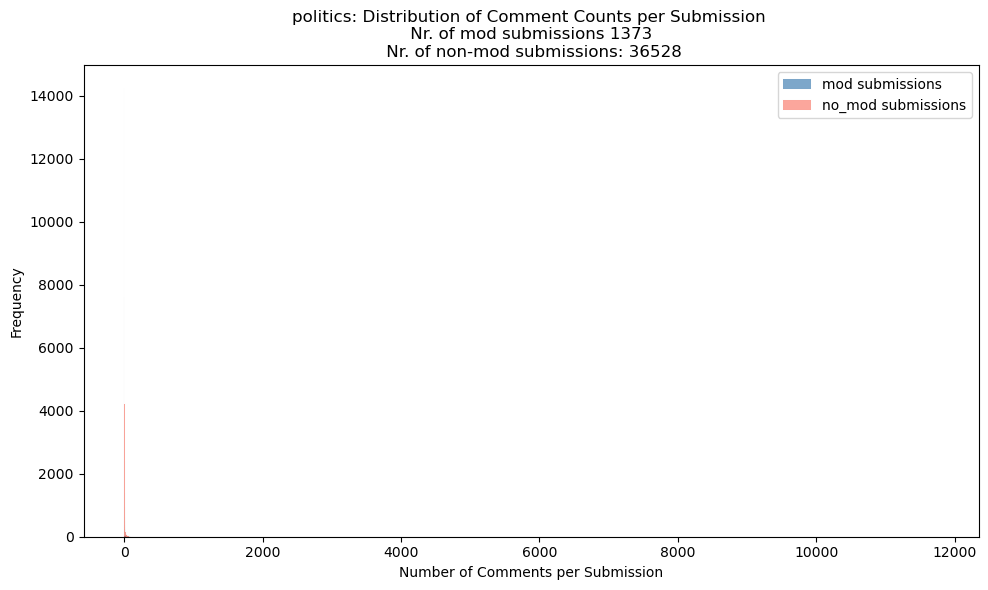

In [54]:
plt.figure(figsize=(10, 6))

sns.histplot(mod_com_per_sub[0], binwidth=1, kde=False, label='mod submissions', color='steelblue', alpha=0.7)
sns.histplot(no_mod_com_per_sub[0], binwidth=1, kde=False, label='no_mod submissions', color='salmon', alpha=0.7)

plt.xlabel('Number of Comments per Submission')
#plt.xlim(0, 80)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n Nr. of mod submissions {len(mod_com_per_sub[0])} \n Nr. of non-mod submissions: {len(no_mod_com_per_sub[0])}')
plt.legend()
plt.tight_layout()

plt.savefig(f"Mod_Hist_{subreddit_here}_Comments_per_Submission.pdf")
plt.show()


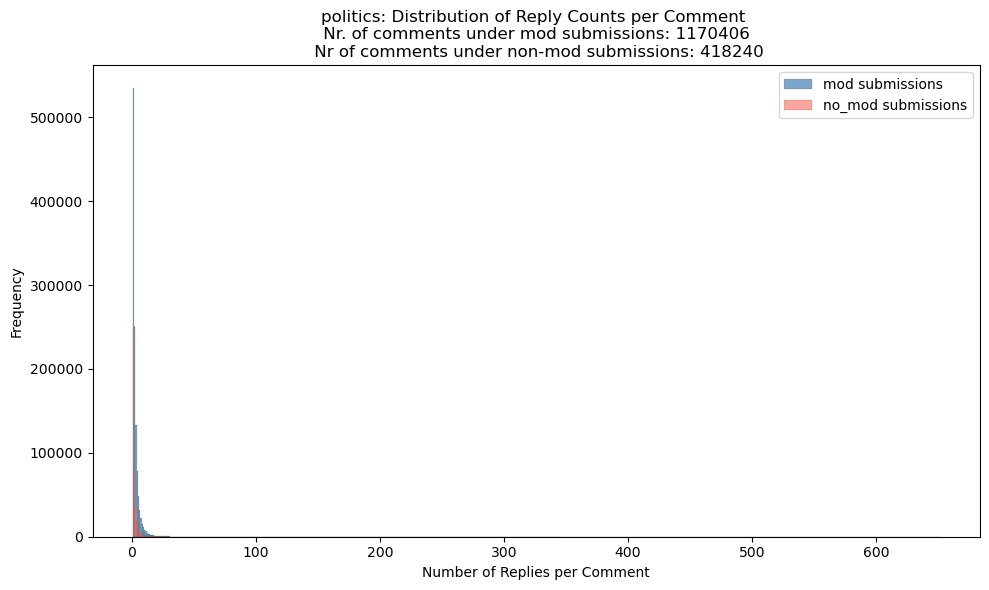

In [55]:
plt.figure(figsize=(10, 6))


sns.histplot(mod_rep_per_com[0], binwidth=1, kde=False, label='mod submissions', color='steelblue', alpha=0.7)
sns.histplot(no_mod_rep_per_com[0], binwidth=1, kde=False, label='no_mod submissions', color='salmon', alpha=0.7)


plt.xlabel('Number of Replies per Comment')
#plt.xlim(0, 20)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n Nr. of comments under mod submissions: {len(mod_rep_per_com[0])} \n Nr of comments under non-mod submissions: {len(no_mod_rep_per_com[0])}')
plt.legend()
plt.tight_layout()
plt.savefig(f"Mod_Hist_{subreddit_here}_Replies_per_Comment.pdf")
plt.show()


/tmp/ipykernel_307/2053345917.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


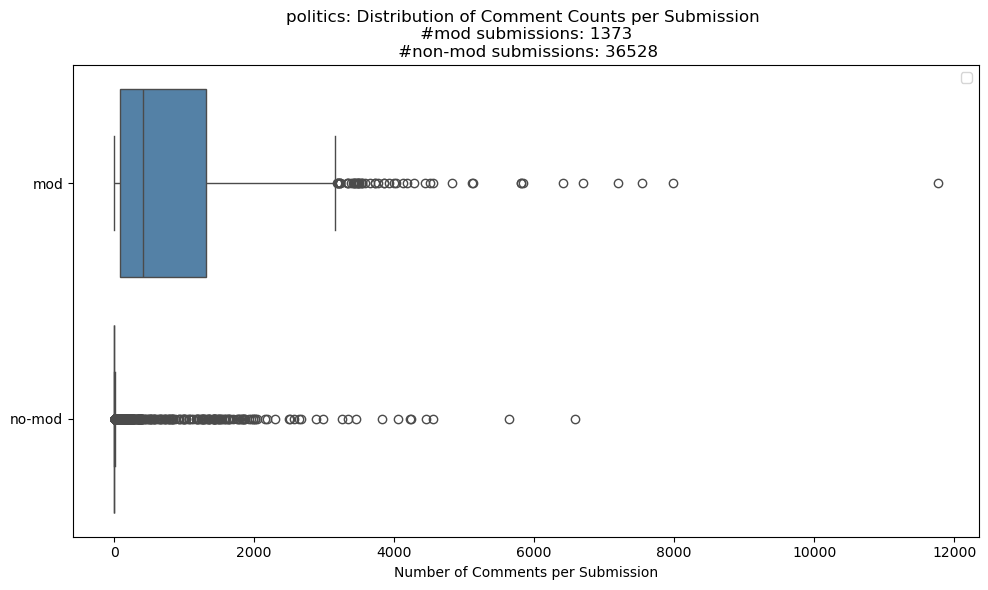

In [56]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([mod_com_per_sub[0], no_mod_com_per_sub[0]], ignore_index=True),
    'type': ['mod'] * len(mod_com_per_sub[0]) + ['no-mod'] * len(no_mod_com_per_sub[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Comments per Submission')
plt.ylabel('')
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n #mod submissions: {len(mod_com_per_sub[0])} \n #non-mod submissions: {len(no_mod_com_per_sub[0])}')
plt.savefig(f"Mod_Box_{subreddit_here}_Comments_per_Submission.pdf")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_307/1890821540.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])


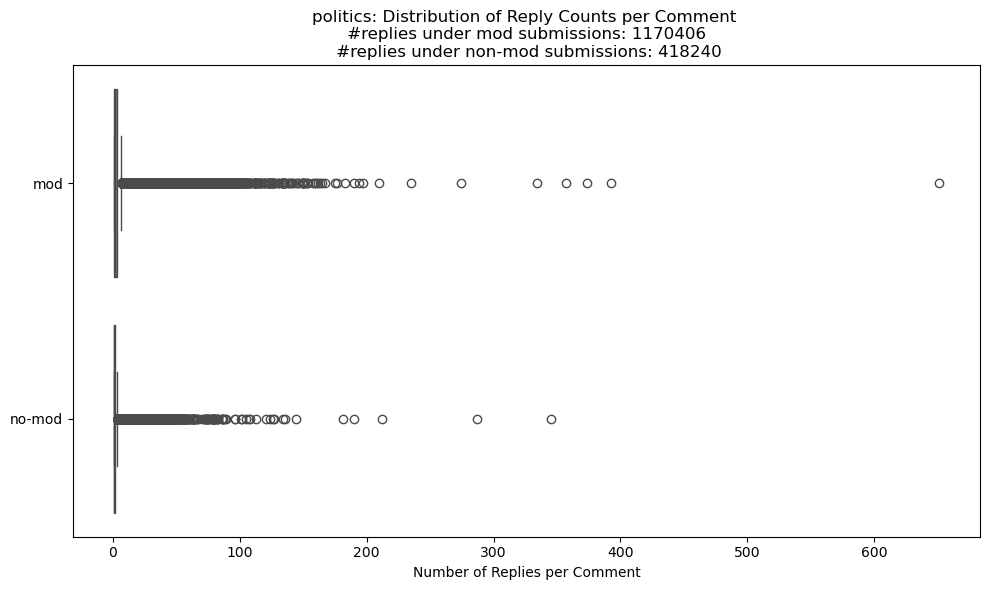

In [57]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([mod_rep_per_com[0], no_mod_rep_per_com[0]], ignore_index=True),
    'type': ['mod'] * len(mod_rep_per_com[0]) + ['no-mod'] * len(no_mod_rep_per_com[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Replies per Comment')
plt.ylabel('')
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n #replies under mod submissions: {len(mod_rep_per_com[0])} \n #replies under non-mod submissions: {len(no_mod_rep_per_com[0])}')
plt.savefig(f"Mod_Box_{subreddit_here}_Replies_per_Comment.pdf")

plt.tight_layout()
plt.show()



***
## **Save and export**


In [124]:
df_no_mod

,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,exact_time_parent,exact_time_submission,author_child,author_parent,author_submission
0,"""c0ae9r5""","""c0aeb6y""","""8tp50""","""politics""","""That is what I'm looking for. Links would be ...","""O'Reilly was actually against FISA and Bush o...","""The video from last nights World's Worst is w...",1.245362e+09,1.245360e+09,1.245356e+09,"""hyperbolic""","""pb1x""","""hyperbolic"""
1,"""c0aeds9""","""c0aee4d""","""8tp50""","""politics""","""As an addendum about their respective network...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1.245368e+09,1.245367e+09,1.245356e+09,"""OMFG-Spot""","""OMFG-Spot""","""hyperbolic"""
2,"""c0aeds9""","""c0aeglj""","""8tp50""","""politics""","""That's awesome and all, but do you have any e...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1.245373e+09,1.245367e+09,1.245356e+09,"""hyperbolic""","""OMFG-Spot""","""hyperbolic"""
3,"""c0aeds9""","""c0aehqw""","""8tp50""","""politics""","""I don't understand your argument. Are you say...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1.245376e+09,1.245367e+09,1.245356e+09,"""rocketvat""","""OMFG-Spot""","""hyperbolic"""
4,"""c0aecro""","""c0aegcb""","""8tp50""","""politics""","""don't you have anything better to do than whi...","""waaah FOX NEWS, do you people have anything b...","""The video from last nights World's Worst is w...",1.245372e+09,1.245365e+09,1.245356e+09,"""clorby""","""Laughsatyou""","""hyperbolic"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175289,"""kfkh5ib""","""kfmd52k""","""18uirzt""","""politics""","""Fact-checking doesnt work if no one hears you...","""Jen Sorensen Future veterans of the informati...","""It's Saturday, folks. Let's all kick back wit...",1.703978e+09,1.703953e+09,1.703952e+09,"""Knightforlife""","""freddiethebaer""","""optimalg"""
4175290,"""kfklsb6""","""kforzbx""","""18uirzt""","""politics""","""This is such a spot on interpretation of what...","""Yakima Herald-Republic and other papers in sy...","""It's Saturday, folks. Let's all kick back wit...",1.704023e+09,1.703954e+09,1.703952e+09,"""bakerfredricka""","""4blockhead""","""optimalg"""
4175291,"""kfmq5kr""","""kfp6tzv""","""18uirzt""","""politics""","""Voting is not nearly that simple. In a first ...","""Courtesy the Star Tribune's Steve Sack ""","""It's Saturday, folks. Let's all kick back wit...",1.704032e+09,1.703983e+09,1.703952e+09,"""glassjar1""","""DoubleTFan""","""optimalg"""
4175292,"""kfp3d4v""","""kfp8xh8""","""18uirzt""","""politics""","""also, try explaining why biden is better to a...",""" Doonesbury by Trudeau ...explain it like I'm...","""It's Saturday, folks. Let's all kick back wit...",1.704033e+09,1.704030e+09,1.703952e+09,"""HaulinBoats""","""4blockhead""","""optimalg"""


In [99]:
# Simulate a large DataFrame with 22 million rows (for testing purposes)
num_rows = len(df_no_mod)
chunk_size = 1_000_000  # Define chunk size (e.g., 1M rows per CSV)


# Define output ZIP file
zip_filename = "../../data/new_preprocessing/splitted_politics_data.zip"
#os.makedirs("output", exist_ok=True)  # Ensure output directory exists

# Create ZIP file and write chunks

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED, allowZip64=True) as zf:
    for i, chunk in enumerate(range(0, num_rows, chunk_size)):
        chunk_df = df_no_mod.iloc[chunk:chunk + chunk_size]  # Slice the DataFrame
        csv_name = f"data_part_{i+1}.csv"

        # Convert DataFrame to CSV and store in memory
        csv_data = chunk_df.to_csv(index=False, quoting=1)

        # Write the CSV string as a new file in the ZIP archive
        zf.writestr(csv_name, csv_data)

print(f"Successfully saved {num_rows} rows in {zip_filename} with {num_rows//chunk_size + 1} parts.")

Successfully saved 4175294 rows in ../../data/new_preprocessing/splitted_politics_data.zip with 5 parts.


In [61]:
politics_missing_date = pd.read_csv("../../data/politics_missing_date.csv")
politics_missing_date

,msg_id_parent,msg_id_child,submission_id,subreddit,exact_time_child,author_child,author_parent,author_submission,finetuned_child_E_norm,finetuned_child_I_norm,...,finetuned_submission_len_norm_z_trans_EMI,self_parent_len_norm_z_trans_EMI,self_child_len_norm_z_trans_EMI,self_submission_len_norm_z_trans_EMI,predictions_label_ft,predictions_score_ft,predictions_prob_disagree,predictions_ft,exact_time_parent,exact_time_submission
0,gbfkjle,gbfl3yn,jpkxmf,politics,1.604732e+09,Banelingz,BungeeBunny,PoliticsModeratorBot,-0.006595,0.015738,...,0.611969,0.326132,-0.167856,0.728648,0,0.5596,0.44040,no_disagreement,NaN,NaN
1,gbfkjle,gbfl7m8,jpkxmf,politics,1.604733e+09,xowasabi,BungeeBunny,PoliticsModeratorBot,-0.240999,-0.333869,...,0.611969,0.326132,0.926226,0.728648,0,0.5450,0.54500,no_disagreement,NaN,NaN
2,gbfkjle,gbflj7g,jpkxmf,politics,1.604733e+09,Tibbaryllis2,BungeeBunny,PoliticsModeratorBot,-0.032163,-0.038440,...,0.611969,0.326132,0.250256,0.728648,1,0.8290,0.82900,disagree,NaN,NaN
3,gbfkjle,gbfm16h,jpkxmf,politics,1.604733e+09,piconet-2,BungeeBunny,PoliticsModeratorBot,-0.038600,-0.090040,...,0.611969,0.326132,0.556973,0.728648,0,0.5615,0.43850,no_disagreement,NaN,NaN
4,gbfknaw,gbfkpr0,jpkxmf,politics,1.604732e+09,trainiac12,tjkp1994,PoliticsModeratorBot,-0.149396,-0.319629,...,0.611969,0.104628,1.366516,0.728648,0,0.9460,0.05417,no_disagreement,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774340,kfkh5ib,kfmd52k,18uirzt,politics,1.703978e+09,Knightforlife,freddiethebaer,optimalg,0.289315,0.222072,...,-0.580210,1.062374,0.498045,-0.857240,0,0.9550,0.04495,no_disagreement,NaN,NaN
774341,kfklsb6,kforzbx,18uirzt,politics,1.704023e+09,bakerfredricka,4blockhead,optimalg,0.192579,0.210383,...,-0.580210,1.165189,-0.381238,-0.857240,0,0.9920,0.00774,no_disagreement,NaN,NaN
774342,kfmq5kr,kfp6tzv,18uirzt,politics,1.704032e+09,glassjar1,DoubleTFan,optimalg,0.078374,0.101258,...,-0.580210,0.242695,-0.122822,-0.857240,1,0.8500,0.85000,disagree,NaN,NaN
774343,kfp3d4v,kfp8xh8,18uirzt,politics,1.704033e+09,HaulinBoats,4blockhead,optimalg,0.137089,0.224533,...,-0.580210,0.207855,-0.789836,-0.857240,0,0.9414,0.05875,no_disagreement,NaN,NaN


In [70]:
print("len submissions: ", len(politics_missing_date['submission_id'].drop_duplicates()))
print("len comments: ", len(politics_missing_date['msg_id_parent'].drop_duplicates()))
print("len replies: ", len(politics_missing_date['msg_id_child'].drop_duplicates()))

len submissions:  1037
len comments:  294828
len replies:  774345


In [80]:
print(len(relevant_submissions[relevant_submissions['id'].isin(politics_missing_date['submission_id'])])) # found
print(len(relevant_comments[relevant_comments['id'].isin(politics_missing_date['msg_id_parent'])])) # found
print(len(replies[replies['id'].isin(politics_missing_date['msg_id_child'])])) # found

1037
294828
774345


In [79]:
df_matched

print(len(df_matched[df_matched['submission_id'].isin(politics_missing_date['submission_id'])].drop_duplicates(subset = "submission_id"))) # found
print(len(df_matched[df_matched['msg_id_parent'].isin(politics_missing_date['msg_id_parent'])].drop_duplicates(subset = "msg_id_parent"))) # found
print(len(df_matched[df_matched['msg_id_child'].isin(politics_missing_date['msg_id_child'])].drop_duplicates(subset = "msg_id_child"))) # found

1037
294828
774345


In [81]:

print(len(df[df['submission_id'].isin(politics_missing_date['submission_id'])].drop_duplicates(subset = "submission_id"))) # found
print(len(df[df['msg_id_parent'].isin(politics_missing_date['msg_id_parent'])].drop_duplicates(subset = "msg_id_parent"))) # found
print(len(df[df['msg_id_child'].isin(politics_missing_date['msg_id_child'])].drop_duplicates(subset = "msg_id_child"))) # found

1037
294828
774345


In [84]:

print(len(df_filtered[df_filtered['submission_id'].isin(politics_missing_date['submission_id'])].drop_duplicates(subset = "submission_id"))) # found
print(len(df_filtered[df_filtered['msg_id_parent'].isin(politics_missing_date['msg_id_parent'])].drop_duplicates(subset = "msg_id_parent"))) # found
print(len(df_filtered[df_filtered['msg_id_child'].isin(politics_missing_date['msg_id_child'])].drop_duplicates(subset = "msg_id_child"))) # found

1037
294828
774345


In [125]:
# remove quoatation marks from politics and Pol Disc.

df_no_mod_stripped = df_no_mod.copy(deep = True)

for col in ['msg_id_parent', 'msg_id_child', 'submission_id',
            'subreddit', 
            'body_child', 'body_parent', 'submission_text',
            'author_child', 'author_parent', 'author_submission']:
    if df_no_mod_stripped[col].dtype == "object":  # Apply only to string columns
        df_no_mod_stripped[col] = df_no_mod_stripped[col].str.strip('"')

df_no_mod_stripped

,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,exact_time_parent,exact_time_submission,author_child,author_parent,author_submission
0,c0ae9r5,c0aeb6y,8tp50,politics,That is what I'm looking for. Links would be a...,O'Reilly was actually against FISA and Bush on...,The video from last nights World's Worst is wo...,1.245362e+09,1.245360e+09,1.245356e+09,hyperbolic,pb1x,hyperbolic
1,c0aeds9,c0aee4d,8tp50,politics,As an addendum about their respective networks...,Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,1.245368e+09,1.245367e+09,1.245356e+09,OMFG-Spot,OMFG-Spot,hyperbolic
2,c0aeds9,c0aeglj,8tp50,politics,"That's awesome and all, but do you have any ev...",Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,1.245373e+09,1.245367e+09,1.245356e+09,hyperbolic,OMFG-Spot,hyperbolic
3,c0aeds9,c0aehqw,8tp50,politics,I don't understand your argument. Are you sayi...,Of course it's fine for Olbermann to occasiona...,The video from last nights World's Worst is wo...,1.245376e+09,1.245367e+09,1.245356e+09,rocketvat,OMFG-Spot,hyperbolic
4,c0aecro,c0aegcb,8tp50,politics,don't you have anything better to do than whin...,"waaah FOX NEWS, do you people have anything be...",The video from last nights World's Worst is wo...,1.245372e+09,1.245365e+09,1.245356e+09,clorby,Laughsatyou,hyperbolic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175289,kfkh5ib,kfmd52k,18uirzt,politics,Fact-checking doesnt work if no one hears you ...,Jen Sorensen Future veterans of the informatio...,"It's Saturday, folks. Let's all kick back with...",1.703978e+09,1.703953e+09,1.703952e+09,Knightforlife,freddiethebaer,optimalg
4175290,kfklsb6,kforzbx,18uirzt,politics,This is such a spot on interpretation of what'...,Yakima Herald-Republic and other papers in syn...,"It's Saturday, folks. Let's all kick back with...",1.704023e+09,1.703954e+09,1.703952e+09,bakerfredricka,4blockhead,optimalg
4175291,kfmq5kr,kfp6tzv,18uirzt,politics,Voting is not nearly that simple. In a first p...,Courtesy the Star Tribune's Steve Sack,"It's Saturday, folks. Let's all kick back with...",1.704032e+09,1.703983e+09,1.703952e+09,glassjar1,DoubleTFan,optimalg
4175292,kfp3d4v,kfp8xh8,18uirzt,politics,"also, try explaining why biden is better to a ...",Doonesbury by Trudeau ...explain it like I'm ...,"It's Saturday, folks. Let's all kick back with...",1.704033e+09,1.704030e+09,1.703952e+09,HaulinBoats,4blockhead,optimalg


In [127]:

print(len(df_no_mod_stripped[df_no_mod_stripped['submission_id'].isin(politics_missing_date['submission_id'])].drop_duplicates(subset = "submission_id"))) # found
print(len(df_no_mod_stripped[df_no_mod_stripped['msg_id_parent'].isin(politics_missing_date['msg_id_parent'])].drop_duplicates(subset = "msg_id_parent"))) # found
print(len(df_no_mod_stripped[df_no_mod_stripped['msg_id_child'].isin(politics_missing_date['msg_id_child'])].drop_duplicates(subset = "msg_id_child"))) # found

1037
294828
774345


In [128]:
df_no_mod_stripped[df_no_mod_stripped['msg_id_child'].isin(politics_missing_date['msg_id_child'])]

,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,exact_time_parent,exact_time_submission,author_child,author_parent,author_submission
3399990,gbfkjle,gbfl3yn,jpkxmf,politics,He did improve the economy. Tariffs are bad no...,"Pre-Covid did trump improve the economy? Also,...",Good evening ! Results can be found below. Na...,1.604732e+09,1.604732e+09,1.604725e+09,Banelingz,BungeeBunny,PoliticsModeratorBot
3399991,gbfkjle,gbfl7m8,jpkxmf,politics,When he came into the white house it was at 4....,"Pre-Covid did trump improve the economy? Also,...",Good evening ! Results can be found below. Na...,1.604733e+09,1.604732e+09,1.604725e+09,xowasabi,BungeeBunny,PoliticsModeratorBot
3399992,gbfkjle,gbflj7g,jpkxmf,politics,No and no. Trump inherited a great economy and...,"Pre-Covid did trump improve the economy? Also,...",Good evening ! Results can be found below. Na...,1.604733e+09,1.604732e+09,1.604725e+09,Tibbaryllis2,BungeeBunny,PoliticsModeratorBot
3399993,gbfkjle,gbfm16h,jpkxmf,politics,Didn't the tariffs get passed to American buye...,"Pre-Covid did trump improve the economy? Also,...",Good evening ! Results can be found below. Na...,1.604733e+09,1.604732e+09,1.604725e+09,piconet-2,BungeeBunny,PoliticsModeratorBot
3399994,gbfknaw,gbfkpr0,jpkxmf,politics,"While the ref isn't looking, pencil in a coupl...",Whats a sports metaphor for what would have to...,Good evening ! Results can be found below. Na...,1.604732e+09,1.604732e+09,1.604725e+09,trainiac12,tjkp1994,PoliticsModeratorBot
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175289,kfkh5ib,kfmd52k,18uirzt,politics,Fact-checking doesnt work if no one hears you ...,Jen Sorensen Future veterans of the informatio...,"It's Saturday, folks. Let's all kick back with...",1.703978e+09,1.703953e+09,1.703952e+09,Knightforlife,freddiethebaer,optimalg
4175290,kfklsb6,kforzbx,18uirzt,politics,This is such a spot on interpretation of what'...,Yakima Herald-Republic and other papers in syn...,"It's Saturday, folks. Let's all kick back with...",1.704023e+09,1.703954e+09,1.703952e+09,bakerfredricka,4blockhead,optimalg
4175291,kfmq5kr,kfp6tzv,18uirzt,politics,Voting is not nearly that simple. In a first p...,Courtesy the Star Tribune's Steve Sack,"It's Saturday, folks. Let's all kick back with...",1.704032e+09,1.703983e+09,1.703952e+09,glassjar1,DoubleTFan,optimalg
4175292,kfp3d4v,kfp8xh8,18uirzt,politics,"also, try explaining why biden is better to a ...",Doonesbury by Trudeau ...explain it like I'm ...,"It's Saturday, folks. Let's all kick back with...",1.704033e+09,1.704030e+09,1.703952e+09,HaulinBoats,4blockhead,optimalg


In [129]:
df_no_mod[df_no_mod['msg_id_child'].isin(politics_missing_date['msg_id_child'])]['exact_time_submission'].isna().any()


False

## Reimport

In [4]:
zip_filename = f"output/splitted_politics_data.zip"


df_chunks = []
with zipfile.ZipFile(zip_filename, 'r') as zf:
    file_list = zf.namelist()  # Get all file names in ZIP
    file_list.sort()  

    print("Files found in ZIP:", file_list)  

    for file in file_list:
        with zf.open(file) as f:
            df_chunk = pd.read_csv(f,  quotechar='"', encoding="utf-8")  
            df_chunks.append(df_chunk) 


df_no_mod = pd.concat(df_chunks, ignore_index=True)


print(f"Successfully loaded {len(df_no_mod)} rows from {zip_filename}")



Files found in ZIP: ['data_part_1.csv', 'data_part_2.csv', 'data_part_3.csv', 'data_part_4.csv', 'data_part_5.csv']
Successfully loaded 4175294 rows from output/splitted_politics_data.zip


## **Get Authors**

In [5]:
df_no_mod

,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,author_child,author_parent,author_submission
0,"""c0ae9r5""","""c0aeb6y""","""8tp50""","""politics""","""That is what I'm looking for. Links would be ...","""O'Reilly was actually against FISA and Bush o...","""The video from last nights World's Worst is w...",1970-01-01 00:00:01.245362278,"""hyperbolic""","""pb1x""","""hyperbolic"""
1,"""c0aeds9""","""c0aee4d""","""8tp50""","""politics""","""As an addendum about their respective network...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1970-01-01 00:00:01.245367620,"""OMFG-Spot""","""OMFG-Spot""","""hyperbolic"""
2,"""c0aeds9""","""c0aeglj""","""8tp50""","""politics""","""That's awesome and all, but do you have any e...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1970-01-01 00:00:01.245373031,"""hyperbolic""","""OMFG-Spot""","""hyperbolic"""
3,"""c0aeds9""","""c0aehqw""","""8tp50""","""politics""","""I don't understand your argument. Are you say...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1970-01-01 00:00:01.245375828,"""rocketvat""","""OMFG-Spot""","""hyperbolic"""
4,"""c0aecro""","""c0aegcb""","""8tp50""","""politics""","""don't you have anything better to do than whi...","""waaah FOX NEWS, do you people have anything b...","""The video from last nights World's Worst is w...",1970-01-01 00:00:01.245372428,"""clorby""","""Laughsatyou""","""hyperbolic"""
...,...,...,...,...,...,...,...,...,...,...,...
4175289,"""kfkh5ib""","""kfmd52k""","""18uirzt""","""politics""","""Fact-checking doesnt work if no one hears you...","""Jen Sorensen Future veterans of the informati...","""It's Saturday, folks. Let's all kick back wit...",1970-01-01 00:00:01.703977996,"""Knightforlife""","""freddiethebaer""","""optimalg"""
4175290,"""kfklsb6""","""kforzbx""","""18uirzt""","""politics""","""This is such a spot on interpretation of what...","""Yakima Herald-Republic and other papers in sy...","""It's Saturday, folks. Let's all kick back wit...",1970-01-01 00:00:01.704023024,"""bakerfredricka""","""4blockhead""","""optimalg"""
4175291,"""kfmq5kr""","""kfp6tzv""","""18uirzt""","""politics""","""Voting is not nearly that simple. In a first ...","""Courtesy the Star Tribune's Steve Sack ""","""It's Saturday, folks. Let's all kick back wit...",1970-01-01 00:00:01.704032059,"""glassjar1""","""DoubleTFan""","""optimalg"""
4175292,"""kfp3d4v""","""kfp8xh8""","""18uirzt""","""politics""","""also, try explaining why biden is better to a...",""" Doonesbury by Trudeau ...explain it like I'm...","""It's Saturday, folks. Let's all kick back wit...",1970-01-01 00:00:01.704033069,"""HaulinBoats""","""4blockhead""","""optimalg"""


In [14]:
all_authors = pd.concat([df_no_mod['author_child'], df_no_mod['author_parent'], df_no_mod['author_submission']])

# Count occurrences
author_counts = Counter(all_authors)

author_df = pd.DataFrame(author_counts.items(), columns=['author', 'count'])
author_df['subreddit'] = subreddit  # Optional: add subreddit info

author_df['author'] = author_df['author'].apply(lambda x: x.strip('"'))


author_df.to_csv("output/politics_authors.csv", index = False)

In [15]:
len(author_df)

721672

***
## **Descriptive Stats**

In [74]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

4360721
Unique Users:  4044721


In [38]:
#pd.DataFrame(list(authors)).to_csv("output/politics_authors.csv", index = False)

### Time Stats and originally pulled counts

In [75]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")




Time Frame 
---------------------------------------------
Beginning of time frame: 2007-08-06
End of time frame: 2023-12-31
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 4609228
Number of comments and replies: 187786794
---------------------------------------------



### Descriptive Stats after Matching

In [76]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  6637133
Number of unique comments:  2247130
Number of unique submissions:  56489


### Descriptive Stats after cleaning for high quality texts

In [78]:
#df
df_filtered

,msg_id_parent,msg_id_child,submission_id,subreddit,body_child,body_parent,submission_text,exact_time_child,author_child,author_parent,author_submission
0,"""c0ae9r5""","""c0aeb6y""","""8tp50""","""politics""","""That is what I'm looking for. Links would be ...","""O'Reilly was actually against FISA and Bush o...","""The video from last nights World's Worst is w...",1970-01-01 00:00:01.245362278,"""hyperbolic""","""pb1x""","""hyperbolic"""
1,"""c0aeds9""","""c0aee4d""","""8tp50""","""politics""","""As an addendum about their respective network...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1970-01-01 00:00:01.245367620,"""OMFG-Spot""","""OMFG-Spot""","""hyperbolic"""
2,"""c0aeds9""","""c0aeglj""","""8tp50""","""politics""","""That's awesome and all, but do you have any e...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1970-01-01 00:00:01.245373031,"""hyperbolic""","""OMFG-Spot""","""hyperbolic"""
3,"""c0aeds9""","""c0aehqw""","""8tp50""","""politics""","""I don't understand your argument. Are you say...","""Of course it's fine for Olbermann to occasion...","""The video from last nights World's Worst is w...",1970-01-01 00:00:01.245375828,"""rocketvat""","""OMFG-Spot""","""hyperbolic"""
4,"""c0aecro""","""c0aegcb""","""8tp50""","""politics""","""don't you have anything better to do than whi...","""waaah FOX NEWS, do you people have anything b...","""The video from last nights World's Worst is w...",1970-01-01 00:00:01.245372428,"""clorby""","""Laughsatyou""","""hyperbolic"""
...,...,...,...,...,...,...,...,...,...,...,...
4177016,"""kfkh5ib""","""kfmd52k""","""18uirzt""","""politics""","""Fact-checking doesnt work if no one hears you...","""Jen Sorensen Future veterans of the informati...","""It's Saturday, folks. Let's all kick back wit...",1970-01-01 00:00:01.703977996,"""Knightforlife""","""freddiethebaer""","""optimalg"""
4177017,"""kfklsb6""","""kforzbx""","""18uirzt""","""politics""","""This is such a spot on interpretation of what...","""Yakima Herald-Republic and other papers in sy...","""It's Saturday, folks. Let's all kick back wit...",1970-01-01 00:00:01.704023024,"""bakerfredricka""","""4blockhead""","""optimalg"""
4177018,"""kfmq5kr""","""kfp6tzv""","""18uirzt""","""politics""","""Voting is not nearly that simple. In a first ...","""Courtesy the Star Tribune's Steve Sack ""","""It's Saturday, folks. Let's all kick back wit...",1970-01-01 00:00:01.704032059,"""glassjar1""","""DoubleTFan""","""optimalg"""
4177019,"""kfp3d4v""","""kfp8xh8""","""18uirzt""","""politics""","""also, try explaining why biden is better to a...",""" Doonesbury by Trudeau ...explain it like I'm...","""It's Saturday, folks. Let's all kick back wit...",1970-01-01 00:00:01.704033069,"""HaulinBoats""","""4blockhead""","""optimalg"""


In [79]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  4177021
Unique Comments:  1590166
Unique Submissions:  37916


In [80]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  722357


### No Mods

In [83]:
print("Unique Replies: ", len(df_no_mod['msg_id_child'].unique()))
print("Unique Comments: ", len(df_no_mod['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df_no_mod['submission_id'].unique()))

Unique Replies:  4175294
Unique Comments:  1588646
Unique Submissions:  37901


In [84]:
print("Unique Users: ", len(set(df_no_mod['author_child']).union(df_no_mod['author_parent'], df_no_mod['author_submission'])))

Unique Users:  721672
